<a href="https://colab.research.google.com/github/j3nguyen/user_item_embeddings/blob/master/NextAction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
# import gensim
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel

# spacy for lemmatization
# import spacy

# NLTK for stopwords and stemming
# from nltk.stem.porter import * 
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')

# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import keras

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Activation, TimeDistributed
from keras.optimizers import Adam

In [0]:
df = pd.read_csv("events.csv")

In [6]:
df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [0]:
# reformat the data set
visitor_ids = df.visitorid.unique()

In [8]:
df.shape

(2756101, 5)

In [19]:
df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [0]:
action_to_idx = {"view": 0, "addtocart": 1, "transaction": 2}

In [68]:
# build the data set

a = df[df.visitorid == visitor_ids[342]].sort_values("timestamp").event.values
a = list(map(lambda x: action_to_idx[x],a))
a

[0, 0, 0]

In [0]:
visitor_activity = {}

for visitor in visitor_ids[:100000]:
  # get user's actions in order of time
  actions = df[df.visitorid == visitor].sort_values("timestamp").event.values
  
  if len(actions) > 50:
    actions = list(map(lambda x: action_to_idx[x],actions)) [:51] 
    visitor_activity[visitor] = actions

In [0]:
#create the LSTM network
hidden_size = 64
num_actions = len(action_to_idx)
input_length = 50

# model = Sequential()
# model.add(Embedding(
#     input_dim=num_actions,
#     output_dim=hidden_size, #hidden layer dimension
#     input_length=input_length,
#     trainable=True
#   )
# )

# model.add(LSTM(hidden_size, return_sequences=True))
# model.add(Dropout(rate=0.5))
# model.add(Activation('softmax'))


model = Sequential()
model.add(Embedding(num_actions, hidden_size, input_length=input_length))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=False))

model.add(Dropout(rate=0.5))
# model.add(TimeDistributed(Dense(num_actions)))
# model.add(Activation('softmax'))
model.add(Dense(num_actions, activation='softmax'))


In [0]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 64)            192       
_________________________________________________________________
lstm_11 (LSTM)               (None, 50, 64)            33024     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 66,435
Trainable params: 66,435
Non-trainable params: 0
_________________________________________________________________


In [72]:
max(list(map(lambda x: len(x),visitor_activity.values())))

2252

In [0]:
from keras.utils import to_categorical

In [0]:
actions = visitor_activity.values()
X_train = np.array(list(map(lambda x: x[:-1], actions))) # one-hot-encode
y_train = to_categorical(np.array(list(map(lambda x: x[50], actions))), num_classes=3) # shift sequence on step forward


In [52]:
X_train.shape

(422, 50)

In [57]:
h = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1, verbose=1)

Train on 379 samples, validate on 43 samples
Epoch 1/50
379/379 [==============================] - 3s 7ms/step - loss: 0.7788 - acc: 0.6464 - val_loss: 0.3277 - val_acc: 0.9302
Epoch 2/50
379/379 [==============================] - 0s 1ms/step - loss: 0.3359 - acc: 0.9314 - val_loss: 0.3027 - val_acc: 0.9302
Epoch 3/50
379/379 [==============================] - 0s 1ms/step - loss: 0.3005 - acc: 0.9314 - val_loss: 0.2936 - val_acc: 0.9302
Epoch 4/50
379/379 [==============================] - 1s 1ms/step - loss: 0.2803 - acc: 0.9314 - val_loss: 0.3057 - val_acc: 0.9302
Epoch 5/50
379/379 [==============================] - 0s 1ms/step - loss: 0.2786 - acc: 0.9340 - val_loss: 0.2972 - val_acc: 0.9302
Epoch 6/50
379/379 [==============================] - 0s 1ms/step - loss: 0.2643 - acc: 0.9261 - val_loss: 0.3020 - val_acc: 0.9302
Epoch 7/50
379/379 [==============================] - 0s 1ms/step - loss: 0.2292 - acc: 0.9367 - val_loss: 0.3192 - val_acc: 0.9302
Epoch 8/50
379/379 [===========

In [0]:
pred_prob = model.predict(X_train)

In [0]:
y_pred = np.argmax(pred_prob,axis=1)
# pred_prob

In [0]:
y_true = np.argmax(y_train,axis=1)

In [0]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[392   1   0]
 [  9   9   1]
 [  4   1   5]]


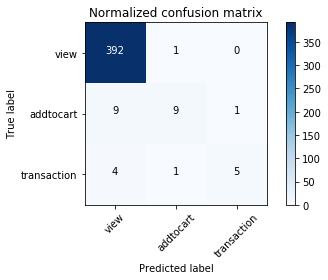

In [76]:
conf=confusion_matrix(y_true,y_pred)
plt.figure()
plot_confusion_matrix(conf, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

In [0]:
embeddings = model.get_layer(index = 0)
# embeddings = embeddings.get_weights()[0]
# embeddings = embeddings / np.linalg.norm(embeddings, axis = 1).reshape((-1, 1))
# embeddings = np.nan_to_num(embeddings)

In [84]:
embeddings.get_weights()[0]

array([[ 0.04585326,  0.01076845, -0.08171535,  0.10055   , -0.01817397,
         0.01684655, -0.00306664,  0.09228728,  0.07403877, -0.09677538,
         0.02304918,  0.10190149, -0.06870894, -0.07216837, -0.04817696,
         0.0794572 , -0.09949838, -0.05945623, -0.04978979, -0.10459855,
         0.06233083,  0.07004292, -0.08426604,  0.10353775,  0.00151103,
         0.09921861,  0.07828525,  0.00498787,  0.03362969, -0.07392991,
         0.0313994 ,  0.08407332,  0.10653617,  0.00124411, -0.08694055,
         0.07496162, -0.00358712,  0.02820783, -0.1039665 , -0.02531488,
        -0.08458795,  0.11082289,  0.0451623 ,  0.08646761,  0.04267707,
         0.08583654, -0.07395535,  0.07803154, -0.1044822 , -0.11497081,
        -0.0820353 ,  0.07192457, -0.07335716, -0.08028925,  0.02952341,
         0.08731241, -0.03832633,  0.10378686,  0.01052172, -0.0737609 ,
         0.10678974, -0.07516605, -0.05325273, -0.08903056],
       [-0.29119533, -0.05731317,  0.21164691, -0.23047082,  0.